### Домашнее задание «Сверточные нейронные сети: практическое применение»

Классификация изображений: Cats vs Dogs  
Обучить модель классификации изображение на 2 класса. Исходные данные и валидация решения на kaggle в рамках контеста Cats vs Dogs. Шаблон ipython-ноутбука для решения можно скачать по ссылке. Решения необходимо прислать в виде ipython-ноутбука с указанием значения метрики на Leaderboard. Задание засчитывается при значениях метрики Log Loss меньше 0.3.

## Dogs vs Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg16

print(tf.__version__)
print(tf.executing_eagerly())

2.6.0
True


### Функции загрузки данных

In [2]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob(r'*train\*.jpg')
test_files = glob(r'*test\*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # предобработка для VGG16

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
                       
            #mean = np.mean(x, axis=0)
            #std = np.std(x, axis=0)
            #x = [(i-mean) / std for i in x]
            #x = x / np.linalg.norm(x, axis=1)[:, None] 
            
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

### Визуализируем примеры для обучения

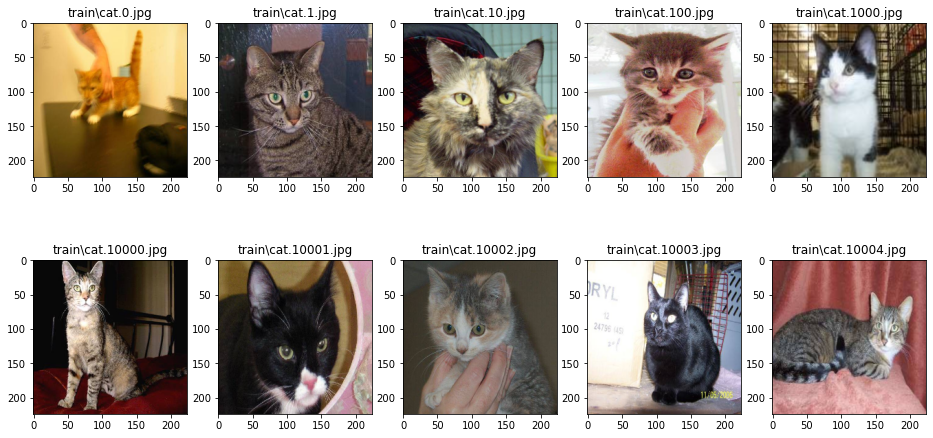

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

### Загружаем предобученную модель

In [4]:
# base_model - объект класса keras.models.Model (Functional Model)
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [5]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Добавляем полносвязный слой

In [6]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-5].output

# или x = tf.keras.layers.GlobalAveragePooling2D()(x) 
# или x = tf.keras.layers.GlobalMaxPooling2D()(x)
# или x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)

# kernel_regularizer: Регуляризатор для применения штрафа к ядру слоя
# bias_regularizer: Регуляризатор для применения штрафа к смещению слоя
# activity_regularizer: Регуляризатор для применения штрафа к выходным данным слоя

x = tf.keras.layers.Dense(1,        # один выход (бинарная классификация)
                          activation = 'sigmoid',    # функция активации
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)
                          #kernel_initializer='he_uniform')(x)
                          #kernel_regularizer=tf.keras.regularizers.l1(1e-4))
                          #kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                          #bias_regularizer=tf.keras.regularizers.l2(1e-4))(x)
                          #activity_regularizer=tf.keras.regularizers.l2(1e-5))(x)  

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

#### L2 Norm

from scipy.spatial.distance import cdist  
res = cdist(test, train, metric='euclidean')  

или  

x, y = test, train  
x2 = np.sum(x**2, axis=1, keepdims=True)  
y2 = np.sum(y**2, axis=1)  
xy = np.dot(x, y.T)  
dist = np.sqrt(x2 - 2*xy + y2)  

или

train = train / np.linalg.norm(train, axis=1)[:, None]  
test = test / np.linalg.norm(test, axis=1)[:, None]  

### Выводим архитектуру модели

In [7]:
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

### Компилируем модель и запускаем обучение

In [8]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss)
              metrics=['accuracy'])

In [9]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
LR_callback = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=2,
                               factor=0.5, min_lr=0.00001)
EarlyStop_callback = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)

my_callback=[EarlyStop_callback, LR_callback]

In [10]:
val_samples = 5  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

In [11]:
# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=10,  # число вызовов генератора за эпоху
          epochs=100,  # число эпох обучения
          validation_data=validation_data)
          #callbacks=my_callback)

Epoch 1/100
10/10 [==============================] - 49s 5s/step - loss: 0.5455 - accuracy: 0.7625 - val_loss: 1.9561 - val_accuracy: 0.8000
Epoch 2/100
10/10 [==============================] - 49s 5s/step - loss: 0.4419 - accuracy: 0.8125 - val_loss: 0.0467 - val_accuracy: 1.0000
Epoch 3/100
10/10 [==============================] - 51s 5s/step - loss: 0.3321 - accuracy: 0.8469 - val_loss: 0.3471 - val_accuracy: 0.8000
Epoch 4/100
10/10 [==============================] - 59s 6s/step - loss: 0.2819 - accuracy: 0.8750 - val_loss: 0.3369 - val_accuracy: 0.8000
Epoch 5/100
10/10 [==============================] - 59s 6s/step - loss: 0.2320 - accuracy: 0.8938 - val_loss: 0.1492 - val_accuracy: 1.0000
Epoch 6/100
10/10 [==============================] - 49s 5s/step - loss: 0.2248 - accuracy: 0.9094 - val_loss: 0.0715 - val_accuracy: 1.0000
Epoch 7/100
10/10 [==============================] - 50s 5s/step - loss: 0.2775 - accuracy: 0.9125 - val_loss: 0.0222 - val_accuracy: 1.0000
Epoch 8/100
1

Epoch 59/100
10/10 [==============================] - 66s 7s/step - loss: 0.1751 - accuracy: 0.9156 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 60/100
10/10 [==============================] - 63s 6s/step - loss: 0.1440 - accuracy: 0.9375 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 61/100
10/10 [==============================] - 54s 5s/step - loss: 0.1237 - accuracy: 0.9469 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 62/100
10/10 [==============================] - 59s 6s/step - loss: 0.1568 - accuracy: 0.9312 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 63/100
10/10 [==============================] - 66s 7s/step - loss: 0.1819 - accuracy: 0.9406 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 64/100
10/10 [==============================] - 66s 7s/step - loss: 0.2009 - accuracy: 0.9250 - val_loss: 0.0046 - val_accuracy: 1.0000
Epoch 65/100
10/10 [==============================] - 66s 7s/step - loss: 0.2124 - accuracy: 0.9187 - val_loss: 0.0070 - val_accuracy: 1.0000
Epoch 

In [13]:
model.save('cats-dogs-vgg16.hdf5')

### Предсказания на проверочной выборке

In [14]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

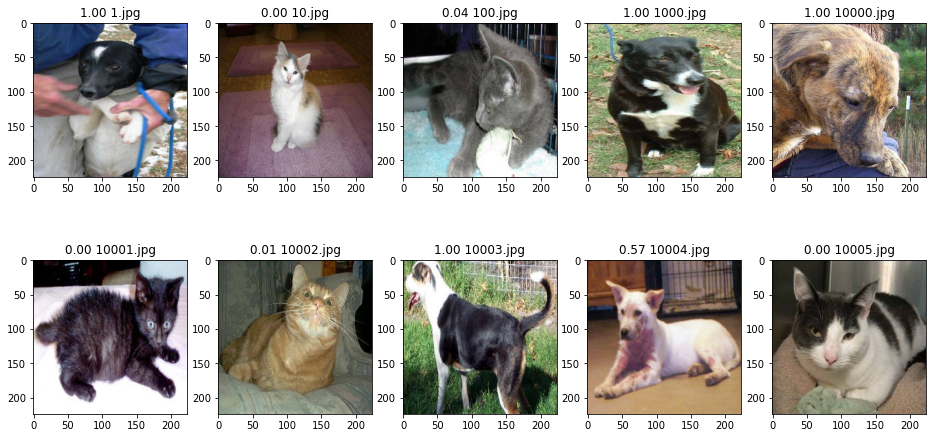

In [15]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

### Готовим данные для отправки

In [16]:
import re

with open('submit.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

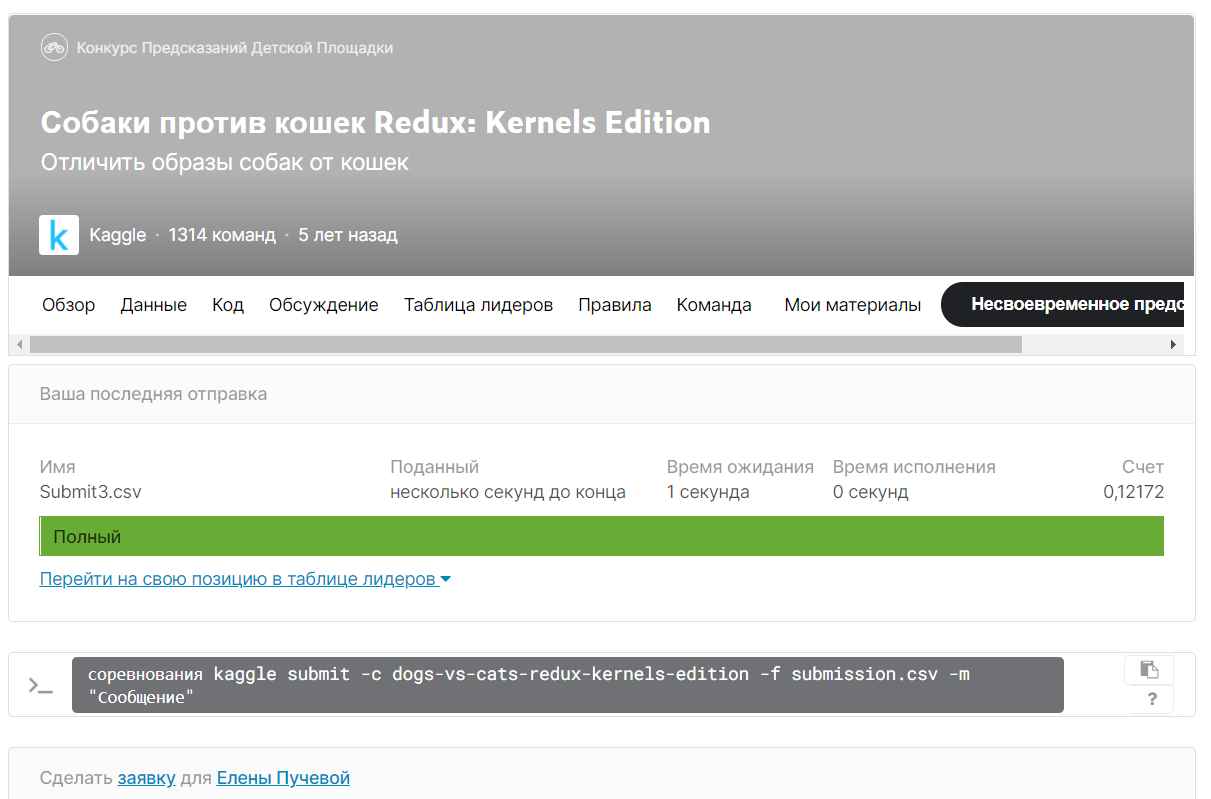